## Imports

In [1]:
# imports
import sys
import sklearn
import tensorflow as tf

import numpy as np
import os
import glob
import json
import time
import librosa
from pathlib import Path
import IPython.display as ipd
import itertools 
import io

# random seed to ensure consistent results during the tutorial
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# check tensorflow version
tf.__version__

'2.7.0'

# 1. Datasets

---

## Load custom made trial data

In [2]:
#filepath = tf.keras.utils.get_file(Path('_data/TinyUrbanSound8k_datasets.zip').resolve(),
 #                               download_link,
  #                              cache_subdir=Path('./_data/').resolve(),
   #                             extract=True)
filepath = tf.keras.utils.get

AttributeError: module 'keras.api._v2.keras.utils' has no attribute 'get'

### Visualizing the reconstructions

One way to ensure that an autoencoder is trained properly is to **compare the inputs and outputs** of our test_dataset: the differences should not be too significant. Let's plot a few images from the test set as well as their reconstructions:

In [3]:
# function to plot reconstructions
def visualize_reconstructions(test_dataset, autoencoder, classes):
    ncols, nrows  = 2, 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

    if tf.is_tensor(test_dataset):
        iterator = test_dataset
    else:
        iterator = test_dataset.shuffle(buffer_size=800).as_numpy_iterator()

    # iterate over dataset
    for i, sample in enumerate(iterator):
    
        # predict some test samples
        if tf.is_tensor(test_dataset):
            X_pred = autoencoder.predict(sample)
            X_true = sample
            label = ''
        else:
            one_hot = sample[1]
            label = classes[np.argmax(one_hot)]
            X_pred = autoencoder.predict(sample[0])
            X_true = sample[0]

        # plot spectrograms
        ax[i][0].imshow(np.squeeze(X_true), origin='lower', aspect='auto')
        ax[i][0].axis('off')
        ax[i][0].set_ylabel(label)
        ax[i][1].imshow(np.squeeze(X_pred), origin='lower', aspect='auto')
        ax[i][1].axis('off')

        if i == 0:
            ax[i][0].set_title('Input Image')
            ax[i][1].set_title('Reconstruction')
        
        if i == nrows-1:
            break

pre-define autoencoder structure

In [4]:
def get_autoencoder_dense(input_shape, dense_layers, codings_size):
    
    # ENCODER --------------------------------------------------
    # encoder input
    encoder_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda x: x)(encoder_input)

    # flatten spectrogram
    x = tf.keras.layers.Flatten()(x)

    # dense layers
    for d in dense_layers:
        x = tf.keras.layers.Dense(d)(x)

    # spectrogram encoded
    latent_dimension = tf.keras.layers.Dense(codings_size, name='latent_dimension')(x)
    encoder_dense = tf.keras.Model(encoder_input, latent_dimension, name='encoder_dense')


    # DECODER --------------------------------------------------
    # decoder input
    decoder_input = tf.keras.layers.Input(shape=latent_dimension.shape[1:])
    x = tf.keras.layers.Lambda(lambda x: x)(decoder_input)

    # dense layers
    for d in dense_layers[::-1]:
        x = tf.keras.layers.Dense(d)(x)

    # Dense layer with amount of neurons in input layer 
    x = tf.keras.layers.Dense(input_shape[0]*input_shape[1]*input_shape[2])(x)

    # reshape to input spectrogram shape
    x = tf.keras.layers.Reshape(input_shape)(x)

    # setup decoder model
    decoded_dimension = tf.keras.layers.Lambda(lambda x: x)(x)
    decoder_dense = tf.keras.Model(decoder_input, decoded_dimension, name='decoder_dense')


    # AUTOENCODER --------------------------------------------------
    encodings = encoder_dense(encoder_input)
    decodings = decoder_dense(encodings)
    autoencoder_dense = tf.keras.Model(encoder_input, decodings, name='autoencoder_dense')

    encoder_dense.summary()
    decoder_dense.summary()
    autoencoder_dense.summary()

    return autoencoder_dense, encoder_dense, decoder_dense

### Visualizing the MNIST latent dimension

Now, that we have trained a stacked autoencoder, we can use it to reduce the dataset's dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms, but one big advantage of autoencoders is that they can handle large datasets with many instances and features. So one strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization, for example **t-distributed stochastic neighbor embedding (t-SNE)** method.

These data encodings via autoencoders are often the starting point for subsequent clustering or classification methods. The encoding mechanism of an autoencoder serves as feature extractor from high-dimensional data like images or audio.  

In [ ]:
from sklearn.manifold import TSNE

def visualize_encodings(test_dataset, encoder, classes):

    # get labels as digits
    y_test = []
    for feature, one_hot in test_dataset.as_numpy_iterator():
        y_test.append(np.argmax(one_hot))
    y_test = np.array(y_test)
    
    # let encoder predict test set
    X_test_latent = encoder.predict(test_dataset)

    # use tsne as dimensionality reduction to 2-D
    tsne = TSNE()
    X_test_latent_2D = tsne.fit_transform(X_test_latent.reshape(X_test_latent.shape[0], -1))

    # setup figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.tab10(np.linspace(0, 1, len(classes)))))

    # plot each class in latent dimension
    for l in np.unique(y_test):
        ix = np.where(y_test == l)
        ax.scatter(X_test_latent_2D[ix, 0], 
                   X_test_latent_2D[ix, 1], 
                   label=classes[l], s=10)

    ax.legend(loc='lower left')

In the first step, we're loading the train and test datasets as shown in the last lecture as well as the saved config file:

In [ ]:
# load config parameters again
with open("_data/TinyUrbanSound8k_config.json", "r") as read_file:
    config = json.load(read_file)

# autotune computation
AUTOTUNE = tf.data.experimental.AUTOTUNE

# normalize data or not
NORMALIZE = False

# mfccs or not
MFCCS = False

# TRAIN AND EVAL DATASET ---------------------------------------------
dataset = tf.data.experimental.load(f'./_data/TinyUrbanSound8k_train', 
                                    (tf.TensorSpec(shape=(config['n_mels'], config['n_frames'], 1), dtype=tf.float32, name=None), 
                                     tf.TensorSpec(shape=(len(config['classes']),), dtype=tf.uint8, name=None)), 
                                     compression='GZIP')

# scale spectrogram amplitude logarithmically
dataset = dataset.map(lambda mel_spec, y: (tf.math.log(mel_spec + 1e-6), y), num_parallel_calls=AUTOTUNE)

# -------------------------------------------------- 
# NEW: normalize over dataset
if NORMALIZE:
    dataset_max = np.max(np.array([np.max(el[0].numpy()) for el in dataset]))
    dataset_min = np.min(np.array([np.min(el[0].numpy()) for el in dataset]))
    dataset = dataset.map(lambda mel_spec, y: ((mel_spec - dataset_min) / (dataset_max - dataset_min) , y), num_parallel_calls=AUTOTUNE)

# NEW: pad spectrogram to 64x64
dataset = dataset.map(lambda mel_spec, y: (tf.image.resize_with_pad(mel_spec, 64, 64), y), num_parallel_calls=AUTOTUNE)

# NEW: convert to mfccs
if MFCCS:
    dataset = dataset.map(lambda mel_spec, y: (tf.squeeze(mel_spec, axis=-1), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda mel_spec, y: (tf.transpose(mel_spec), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda mel_spec, y: (tf.signal.mfccs_from_log_mel_spectrograms(mel_spec)[..., :MFCCS], y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda mel_spec, y: (tf.transpose(mel_spec), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda mel_spec, y: (tf.expand_dims(mel_spec, axis=-1), y), num_parallel_calls=AUTOTUNE)    
    
# NEW: map spectrograms as featuers AND labels
dataset = dataset.map(lambda mel_spec, y: (mel_spec, mel_spec), num_parallel_calls=AUTOTUNE)
# --------------------------------------------------


# shuffle before splitting in train and eval dataset
dataset = dataset.shuffle(buffer_size=4000)

# take first 80% from dataset
train_dataset = dataset.take(3200).shuffle(buffer_size=3200).batch(64).prefetch(AUTOTUNE)

# take last 20% samples from dataset 
eval_dataset = dataset.skip(3200).batch(1).prefetch(AUTOTUNE)



# TEST DATASET -----------------------------------------------------------
test_dataset = tf.data.experimental.load(f'./_data/TinyUrbanSound8k_test', 
                                    (tf.TensorSpec(shape=(config['n_mels'], config['n_frames'], 1), dtype=tf.float32, name=None), 
                                     tf.TensorSpec(shape=(len(config['classes']),), dtype=tf.uint8, name=None)), 
                                    compression='GZIP')

# scale spectrogram amplitude logarithmically
test_dataset = test_dataset.map(lambda mel_spec, y: (tf.math.log(mel_spec + 1e-6), y), num_parallel_calls=AUTOTUNE)

# -------------------------------------------------- 
# NEW: normalize over dataset
if NORMALIZE:
    test_dataset_max = np.max(np.array([np.max(el[0].numpy()) for el in test_dataset]))
    test_dataset_min = np.min(np.array([np.min(el[0].numpy()) for el in test_dataset]))
    test_dataset = test_dataset.map(lambda mel_spec, y: ((mel_spec - test_dataset_min) / (test_dataset_max - test_dataset_min) , y), num_parallel_calls=AUTOTUNE)

# NEW: pad spectrogram to 64x64
test_dataset = test_dataset.map(lambda mel_spec, y: (tf.image.resize_with_pad(mel_spec, 64, 64), y), num_parallel_calls=AUTOTUNE)

# NEW: convert to mfccs
if MFCCS:
    test_dataset = test_dataset.map(lambda mel_spec, y: (tf.squeeze(mel_spec, axis=-1), y), num_parallel_calls=AUTOTUNE)
    test_dataset = test_dataset.map(lambda mel_spec, y: (tf.transpose(mel_spec), y), num_parallel_calls=AUTOTUNE)
    test_dataset = test_dataset.map(lambda mel_spec, y: (tf.signal.mfccs_from_log_mel_spectrograms(mel_spec)[..., :MFCCS], y), num_parallel_calls=AUTOTUNE)
    test_dataset = test_dataset.map(lambda mel_spec, y: (tf.transpose(mel_spec), y), num_parallel_calls=AUTOTUNE)
    test_dataset = test_dataset.map(lambda mel_spec, y: (tf.expand_dims(mel_spec, axis=-1), y), num_parallel_calls=AUTOTUNE)    

# --------------------------------------------------

# batch dataset
test_dataset = test_dataset.cache().batch(1).prefetch(AUTOTUNE)



# Dataset attributes ------------------------------
print('Attribues of TRAINING set: (SPECS AS FEATUERS AND LABELS)')
print('--------------------------')
print('Feature_shape: %s' % train_dataset.element_spec[0].shape)
print('Label_shape: %s' % train_dataset.element_spec[1].shape)
print('Number of batches: %s' % len(list(train_dataset)))
print('\n')

print('Attribues of EVAL set: (SPECS AS FEATUERS AND LABELS)')
print('--------------------------')
print('Feature_shape: %s' % eval_dataset.element_spec[0].shape)
print('Label_shape: %s' % eval_dataset.element_spec[1].shape)
print('Number of batches: %s' % len(list(eval_dataset)))
print('\n')

print('Attribues of TEST set: (WITH CLASS-LABELS)')
print('--------------------------')
print('Feature_shape: %s' % test_dataset.element_spec[0].shape)
print('Label_shape: %s' % test_dataset.element_spec[1].shape)
print('Number of batches: %s' % len(list(test_dataset)))
print('\n')

NotFoundError: Could not find metadata file. [Op:LoadDataset]

In [ ]:
classes_tus8k = config['classes']
classes_tus8k

['children_playing', 'dog_bark', 'siren', 'street_music']

---

---

# 2. Autoencoders

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called **latent representations** or codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for **dimensionality reduction**, especially for visualization purposes. Autoencoders also act as **feature detectors**, and they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are generative models: they are capable of **randomly generating new data** that looks very similar to the training data. For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.

Autoencoders simply learn to copy their inputs to their outputs. This may sound
like a trivial task, but we will see that constraining the network in various ways
can make it rather difficult. For example, you can limit the size of the latent rep-
resentations, or you can add noise to the inputs and train the network to recover
the original inputs. These constraints prevent the autoencoder from trivially
copying the inputs directly to the outputs, which forces it to learn efficient ways
of representing the data. In short, the codings are byproducts of the autoencoder
learning the identity function under some constraints.

---

### Train Vanilla Autoencoder on TinyUrbanSound8k specs

In [ ]:
# get data input shape
input_shape = train_dataset.element_spec[0].shape[1:]

# get autoencoder 
dense_layers = [256, 64]
codings_size = 32
ae_dense_tus8k, enc_dense_tus8k, _ = get_autoencoder_dense(input_shape, dense_layers, codings_size)

# compile the model with adam optimizer and mean squeared error as its loss function
ae_dense_tus8k.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, clipnorm=1), 
                     loss='mse', metrics=['mse'])

reduce_lro_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                     factor=0.5, patience=5, verbose=1, 
                                                     mode='min', min_delta=0.0001, 
                                                     cooldown=0, min_lr=0)
# train the model
ae_dense_tus8k.fit(train_dataset,
                 epochs=2, 
                 validation_data=eval_dataset,
                 callbacks=[reduce_lro_cb])

Model: "encoder_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 lambda_3 (Lambda)           (None, 64, 64, 1)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               1048832   
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 latent_dimension (Dense)    (None, 32)                2080      
                                                                 
Total params: 1,067,360
Trainable params: 1,067,360
N

### Visualizing the TUS8k reconstructions

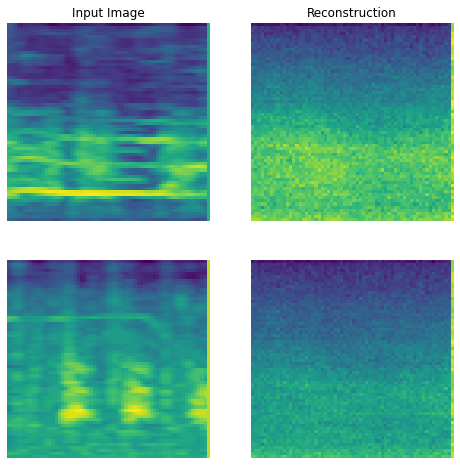

In [ ]:
# call visualize reconstructions function
visualize_reconstructions(test_dataset, ae_dense_tus8k, classes_tus8k)

### Visualizing the TUS8k latent dimension

C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sebastian.bernhardt\Anaconda3\envs\dl4aed\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


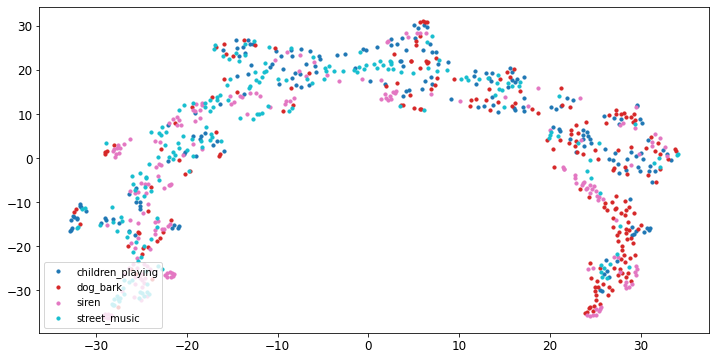

In [ ]:
visualize_encodings(test_dataset, ae_dense_tus8k, classes_tus8k)

---

## 2.2. Convolutional Autoencoders

If you are dealing with audio or images, then simple stacked autoencoders will not work well (unless the audio/images are very small): as we saw in Lecture 03, convolutional neural networks are far better suited than dense networks to work with images. So if you want to build an autoencoder for audio/images, you will need to build a convolutional autoencoder. The encoder is a regular CNN composed of convolutional layers and pooling layers. It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (ie., the number of feature maps). The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this you can use transpose convolutional layers (alternatively, you could combine upsampling layers with convolutional layers). 

In [ ]:
def get_autoencoder_conv(input_shape, filters):

    # ENCODER --------------------------------------------------
    # encoder input
    encoder_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda x: x)(encoder_input)
    
    # iterate filters
    for f  in filters:
        x = tf.keras.layers.Convolution2D(filters=f, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    # spectrogram encoded
    latent_dimension = tf.keras.layers.Lambda(lambda x: x, name='latent_dimension')(x)
    encoder_conv = tf.keras.Model(encoder_input, latent_dimension, name='encoder_conv')


    # DECODER --------------------------------------------------
    # decoder input
    decoder_input = tf.keras.layers.Input(shape=latent_dimension.shape[1:])
    x = tf.keras.layers.Lambda(lambda x: x)(decoder_input)

    for f  in filters[::-1]:
        x = tf.keras.layers.Convolution2DTranspose(filters=f, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    # audio decoded
    x = tf.keras.layers.Convolution2DTranspose(filters=1, kernel_size=(1, 1), activation='linear', padding='same', name='decoder')(x)
    
    # setup decoder model
    decoded_dimension = tf.keras.layers.Lambda(lambda x: x)(x)
    decoder_conv = tf.keras.Model(decoder_input, decoded_dimension, name='decoder')


    # AUTOENCODER --------------------------------------------------
    # put encoder and decoder together
    encodings = encoder_conv(encoder_input)
    decodings = decoder_conv(encodings)
    autoencoder_conv = tf.keras.Model(encoder_input, decodings, name='autoencoder_conv')

    encoder_conv.summary()
    decoder_conv.summary()
    autoencoder_conv.summary()
    
    return autoencoder_conv, encoder_conv, decoder_conv

---

### Train CNN Autoencoder on TinyUrbanSound8k specs

In [ ]:
# get data input shape
input_shape = train_dataset.element_spec[0].shape[1:]

# get autoencoder 
filters = [16, 32, 64, 128, 256, 512] 
ae_conv_tus8k, enc_conv_tus8k, _ = get_autoencoder_conv(input_shape, dense_layers)


# compile the model with adam optimizer and mean squeared error as its loss function
ae_conv_tus8k.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, clipnorm=1), 
                     loss='mse', metrics=['mse'])

reduce_lro_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                     factor=0.5, patience=5, verbose=1, 
                                                     mode='min', min_delta=0.0001, 
                                                     cooldown=0, min_lr=0)
# train the model
ae_conv_tus8k.fit(train_dataset,
                 epochs=2, 
                 validation_data=eval_dataset,
                 callbacks=[reduce_lro_cb])

Model: "encoder_conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 lambda_6 (Lambda)           (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 256)       2560      
                                                                 
 average_pooling2d (AverageP  (None, 32, 32, 256)      0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)       

KeyboardInterrupt: 

### Visualizing the TUS8k reconstructions

In [ ]:
# call visualize reconstructions function
visualize_reconstructions(test_dataset, ae_conv_tus8k, classes_tus8k)

### Visualizing the TUS8k latent dimension

In [ ]:
visualize_encodings(test_dataset, ae_conv_tus8k, classes_tus8k)

---

## 2.3. Recurrent Autoencoders

If you want to build an autoencoder for sequences, such as time series or text (e.g., for unsupervised learning or dimensionality reduction), then **recurrent neural networks** may be better suited than dense networks. Building a recurrent autoencoder is straightforward: the **encoder** is typically a **sequence-to-vector RNN** which compresses the input sequence down to a single vector. The **decoder** is a **vector-to-sequence RNN** that does the reverse. 

This recurrent autoencoder can **process sequences of any length, with 64 dimensions per time step**. Conveniently, this means it can process spectrogram images by **treating each image as a sequence of rows**: at each time step, the RNN will process a single row of 64 pixels. Obviously, you could use a recurrent autoencoder for any kind of sequence. Note that we use a **RepeatVector** layer as the first layer of the decoder, to ensure that its input vector gets fed to the decoder at each time step. As opposed to the previous apporaches, this autoencoder was built with the **sequential API**, which sometimes is less complex to implement: 

In [ ]:
def get_autoencoder_lstm(input_shape, lstm_layers, codings_size):

    # ENCODER --------------------------------------------------
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=3))(inputs)
    
    for l in lstm_layers:
        x = tf.keras.layers.LSTM(l, return_sequences=True)(x)
        
    codings = tf.keras.layers.LSTM(codings_size)(x)
    encoder_lstm = tf.keras.Model(inputs=[inputs], outputs=[codings])

    # DECODER --------------------------------------------------
    decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
    x = tf.keras.layers.RepeatVector(input_shape[0])(decoder_inputs)

    for l in lstm_layers[::-1]:
        x = tf.keras.layers.LSTM(l, return_sequences=True)(x)

    dense_layer = tf.keras.layers.Dense(input_shape[1], activation='linear')
    x = tf.keras.layers.TimeDistributed(dense_layer)(x)

    outputs = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=3))(x)
    decoder_lstm = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

    # AUTOCODER ------------------------------------------------
    codings = encoder_lstm(inputs)
    reconstructions = decoder_lstm(codings)
    autoencoder_lstm = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

    encoder_lstm.summary()
    decoder_lstm.summary()
    autoencoder_lstm.summary()
    
    return autoencoder_lstm, encoder_lstm, decoder_lstm

### Train LSTM Autoencoder on TinyUrbanSound8k data

In [ ]:
# get lstm autoencoder
input_shape = train_dataset.element_spec[0].shape[1:]
lstm_layers = [512]
codings_size = 256
ae_lstm_tus8k, enc_lstm_tus8k, _ = get_autoencoder_lstm(input_shape, lstm_layers, codings_size)

# compile the model with adam optimizer and mean squeared error as its loss function
ae_lstm_tus8k.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, clipnorm=5), 
                      loss='mse',
                      metrics=['mse'])

reduce_lro_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                     factor=0.5, patience=5, verbose=1, 
                                                     mode='min', min_delta=0.0001, 
                                                     cooldown=0, min_lr=0)
# train the model
ae_lstm_tus8k.fit(train_dataset,
                  epochs=1,
                  # validation_data=eval_dataset,
                  callbacks=[reduce_lro_cb]
                  )

NameError: name 'train_dataset' is not defined

### Visualizing the TinyUrbanSound8k reconstructions

In [ ]:
visualize_reconstructions(test_dataset, ae_lstm_tus8k, classes_tus8k)

### Visualizing the TinyUrbanSound8k latent dimension

In [ ]:
visualize_encodings(test_dataset, enc_lstm_tus8k, classes_tus8k)

---

## 2.4. Denoising Autoencoders

Another way to force the autoencoder to learn useful features is to **add noise to its inputs, training it to recover the noise-free inputs**. The noise can be pure **Gaussian noise** added to the inputs, or can be randomly switched-off inputs, just like in **Dropout**. With audio data this noise can also be introduced in the original waveform to simulate analog/digital noise artifacts during training. Denoising applications are manifold in the **audio domain** especially for music and speech data.

The implementation is straightforward: it is a regular stacked autoencoder (dense, cnn or rnn) with an additional Dropout or Gaussian Noise layer applied to the encoders inputs. Recall that the Dropout/Gaussian Noise Layer is only active during training:

In [ ]:
def get_denoising_autoencoder(input_shape, filters, noise=False, dropout=False):

    # ENCODER --------------------------------------------------
    # encoder input
    encoder_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda x: x)(encoder_input)

    # -------------------------------------------------- 
    # NEW: Add Noise or Dropout adfter input
    if noise:
        x = tf.keras.layers.GaussianNoise(0.2)(x)
    if dropout:
        x = tf.keras.layers.Dropout(0.5)(x)
    # -------------------------------------------------- 

    # iterate filters
    for f  in filters:
        x = tf.keras.layers.Convolution2D(filters=f, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    # spectrogram encoded 
    latent_dimension = tf.keras.layers.Lambda(lambda x: x, name='latent_dimension')(x)
    encoder_denoise = tf.keras.Model(encoder_input, latent_dimension, name='encoder_denoise')

    # DECODER --------------------------------------------------
    # decoder input
    decoder_input = tf.keras.layers.Input(shape=latent_dimension.shape[1:])
    x = tf.keras.layers.Lambda(lambda x: x)(decoder_input)

    for f  in filters[::-1]:
        x = tf.keras.layers.Convolution2DTranspose(filters=f, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    # audio decoded
    x = tf.keras.layers.Convolution2DTranspose(filters=1, kernel_size=(1, 1), activation='linear', padding='same', name='decoder')(x)

    # setup decoder model
    decoded_dimension = tf.keras.layers.Lambda(lambda x: x)(x)
    decoder_denoise = tf.keras.Model(decoder_input, decoded_dimension, name='decoder')

    # AUTOENCODER --------------------------------------------------

    # put encoder and decoder together
    encodings = encoder_denoise(encoder_input)
    decodings = decoder_denoise(encodings)
    autoencoder_denoise = tf.keras.Model(encoder_input, decodings, name='autoencoder_denoise')
    
    encoder_denoise.summary()
    decoder_denoise.summary()
    autoencoder_denoise.summary()

    return autoencoder_denoise

In [ ]:
# get denoising autoencoder
input_shape = train_dataset_mnist.element_spec[0].shape[1:]
filters = [8, 16]
ae_denoise_mnist = get_denoising_autoencoder(input_shape, filters, noise=True, dropout=True)

ae_denoise_mnist.compile(loss='mse',
                         optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, clipnorm=1),
                         metrics=['mse'])

ae_denoise_mnist.fit(train_dataset_mnist,
                     epochs=20,
                     validation_data=eval_dataset_mnist)

### Visualizing the reconstructions

In order to visualize denoised images, we need add Gaussian Noise to the test samples: 

In [ ]:
# extract the images from the test set
X_test_mnist = np.array([el[0] for el in test_dataset_mnist.as_numpy_iterator()])
np.random.shuffle(X_test_mnist)

# add noise and dropout layer to test samples
noise = tf.keras.layers.GaussianNoise(0.2)
dropout = tf.keras.layers.Dropout(0.5)
X_test_noisy = dropout(noise(X_test_mnist, training=True), training=True)

# plot reconstructions
visualize_reconstructions(X_test_noisy, ae_denoise_mnist, classes_mnist)

## 2.6. Summary Autoencoders


Autoencoders are unsupervised learning methods that contain dense, convolutional or lstm layers, arranged in a mirrored structure. They encode high-dimensionaly input features into encoding in a latent dimension. Autoencoders are most often used for:

- **Feature extraction** for high-dimensional data, e.g. audio/images (for subsequent classifiers)
- **Clustering the encodings** in the latent dimension
- **Anomaly Detection**: Detect abnormal classes by the reconstruction MSE 
- **Generate new samples** by sampling the latent dimension with Variational Autoencoders


---

## 2.7. Autoencoders for Audio Applications


- Autoencoding Neural Networks as Musical Audio Synthesizers (https://arxiv.org/abs/2004.13172)
- Autoencoders for music sound modeling (http://www.gipsa-lab.fr/~laurent.girin/papers/Roche_et_al_SMC_2019.pdf)
- NSynth (WaveNet-style autoencoder model): https://magenta.tensorflow.org/nsynth
- DDSP: Differentiable Digital Signal Processing: https://magenta.tensorflow.org/ddsp
- MusicVAE: https://magenta.tensorflow.org/music-vae
- A Wavenet for Speech Denoising: http://jordipons.me/apps/speech-denoising-wavenet/
- Neural Composer: https://www.youtube.com/watch?v=UWxfnNXlVy8 | https://github.com/HackerPoet/Composer
- Autoencoder for sound anomaly detection, e.g. http://dcase.community/documents/workshop2020/proceedings/DCASE2020Workshop_Giri_66.pdf 
- auDeep Python toolkit for unsupervised feature learning: https://github.com/auDeep/auDeep

---

### Further reading and resources:

#### Autoencoder
https://www.tensorflow.org/tutorials/generative/autoencoder#first_example_basic_autoencoder \
https://www.tensorflow.org/tutorials/generative/cvae \
https://www.youtube.com/watch?v=Rdpbnd0pCiI \
https://www.youtube.com/watch?v=9zKuYvjFFS8&t=3s \
Kingma, D.P. and Welling, M., 2013. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.


#### GANs:  
https://www.tensorflow.org/tutorials/generative/dcgan \
https://www.coursera.org/specializations/generative-adversarial-networks-gans \
Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A. and Bengio, Y., 2014. Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680). \
Goodfellow, I., Bengio, Y., Courville, A. and Bengio, Y., 2016. Deep learning (Vol. 1, No. 2). Cambridge: MIT press.

#### For both topics:
Chapter 17 in the Hands-On ML book:  
Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow:Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media, 2019.  
https://github.com/ageron/handson-ml2 (Corresponding repo to the book)

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7aa9a1b-e7b2-431b-b8b2-9c4c2699a2ef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>